In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from scipy.signal import savgol_filter
from pykalman import KalmanFilter
from getdata import GetDataset

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


In [2]:
data_orig,target = GetDataset(CreateDataFrame=True).Outputdata()


In [35]:
#Interpolacion para que los datos en x1 sean x distantes
x_data = np.linspace(data_orig[0][0].min(),data_orig[0][0].max(),901)
temp = np.zeros((data_orig.shape[0],901))
for i in range(data_orig.shape[0]):
    temp[i,:] = np.interp(x,data_orig[i][0][:],data_orig[i][1][:])

In [36]:
# Creacion de arreglos matriciales 30x30 2 channels
data = np.zeros((temp.shape[0],temp.shape[1],2))
for i in range(data.shape[0]):
    data[i,:,0] = savgol_filter(temp[i,:], window_length=50, polyorder=2)
    data[i,:,1] = np.gradient(savgol_filter(data[i,:,0], window_length=50, polyorder=2))

In [37]:
torch.manual_seed(42)
shuffle_idx = torch.randperm(3090, dtype = torch.long)
data_shuffle = data[shuffle_idx]
target_shuffle = target[shuffle_idx]
shuffle_idx

tensor([2082, 2966, 2862,  ...,  847, 2232, 1707])

In [179]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, root_dir_derivative, target_shuffle, transform=None):
        self.root_dir = root_dir
        self.root_dir_derivative = root_dir_derivative
        self.target_shuffle = target_shuffle
        self.transform = transform
        self.images = os.listdir(root_dir)
        self.images_derivative = os.listdir(root_dir_derivative)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        img_name_derivative = os.path.join(self.root_dir_derivative, self.images_derivative[idx])

        image = Image.open(img_name)
        image_derivative = Image.open(img_name_derivative)

        if self.transform:
            image = self.transform(image)
            image_derivative = self.transform(image_derivative)

        # Tomar solo los primeros dos canales de la imagen
        image = torch.cat((image, image_derivative), dim=0)[:2, :, :]

        img_filename = self.images[idx].split('.')[0]

        label = self.target_shuffle[idx]

        label = torch.tensor(label, dtype=torch.float)

        return image, label, self.images[idx] 

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:2, :, :]),  # Tomar solo los primeros dos canales
    transforms.Normalize((0.5, 0.5), (0.5, 0.5)),  # Normalizar solo dos canales
    transforms.Lambda(lambda x: (x > 0.64).float())  # Otras transformaciones, si es necesario
])

dataset = CustomImageDataset(
    root_dir='Dataset/img/imagenes',
    root_dir_derivative='Dataset/img/imagenes_derivate',
    target_shuffle=target_shuffle,
    transform=transform,
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
indices = list(range(len(dataset)))

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)


In [159]:
train_dataset.__getitem__(2)


(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor(1.9400),
 '10.png')

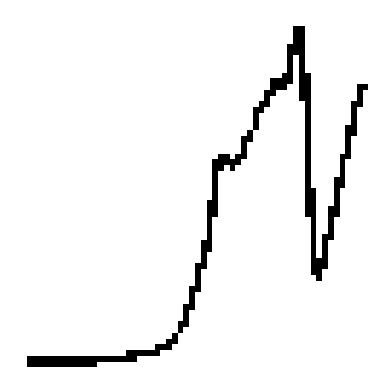

In [180]:
index = 0
image, label, _ = test_dataset[index]

image = image[0].numpy()  
mean = 0.5
std = 0.5
image = (image * std) + mean
image = image.clip(0, 1)  

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [205]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1) 
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

model = CNN()

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lista para almacenar las pérdidas en cada época
losses = []

# Loop de entrenamiento
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels, _) in enumerate(train_loader, 0):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1).float())

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}')



Epoch [1/100], Loss: 2.2857331037521362
Epoch [2/100], Loss: 0.5169681072235107
Epoch [3/100], Loss: 0.49403807520866394
Epoch [4/100], Loss: 0.46571609377861023
Epoch [5/100], Loss: 0.4568882644176483
Epoch [6/100], Loss: 0.4528292417526245
Epoch [7/100], Loss: 0.44315009713172915
Epoch [8/100], Loss: 0.44816861152648924
Epoch [9/100], Loss: 0.43888933062553404
Epoch [10/100], Loss: 0.4426130771636963
Epoch [11/100], Loss: 0.44002697467803953
Epoch [12/100], Loss: 0.438691246509552
Epoch [13/100], Loss: 0.4411697268486023
Epoch [14/100], Loss: 0.43901528120040895
Epoch [15/100], Loss: 0.43902483582496643
Epoch [16/100], Loss: 0.4402234613895416
Epoch [17/100], Loss: 0.4393301010131836
Epoch [18/100], Loss: 0.4391143202781677
Epoch [19/100], Loss: 0.4397810995578766
Epoch [20/100], Loss: 0.4397008717060089
Epoch [21/100], Loss: 0.43936530947685243
Epoch [22/100], Loss: 0.439538437128067
Epoch [23/100], Loss: 0.43978304266929624
Epoch [24/100], Loss: 0.43972870111465456
Epoch [25/100], 

KeyboardInterrupt: 

In [202]:
image, label, di = test_dataset.__getitem__(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)

model = model.to(device)

model.eval()  
with torch.no_grad():
    outputs = model(image)

predicted_bandgap = outputs.mean().item()

print(f"Predicción de Bandgap para el {di}:", predicted_bandgap)


Predicción de Bandgap para el 443.png: 2.746469497680664


In [197]:
print(label)

tensor(2.0700)


In [203]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def compute_regression_metrics(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs = inputs.to(device)  # Mover datos a la GPU
            outputs = model(inputs)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calcular las métricas de regresión
    mae = mean_absolute_error(true_labels, predicted_labels)
    mse = mean_squared_error(true_labels, predicted_labels)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_labels, predicted_labels)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R^2 Score:", r2)

    return mae, mse, rmse, r2


In [204]:
mae, mse, rmse, r2 = compute_regression_metrics(model, test_loader)

Mean Absolute Error (MAE): 0.60040075
Mean Squared Error (MSE): 0.44365448
Root Mean Squared Error (RMSE): 0.6660739
R^2 Score: -0.048785865120640315
